# Forecasting Australia's 2019 Election with PyMC3

<table style="float:right; width: 50%">
<tr><td> <img style="float: left; width: 100%" src="../img/mumbai.jpg"> </td></tr>
</table>

#### Martin Burgess
nousgroup.com

buckleysandnone.com

### Slides:
<b>buckleysandnone.com/pycon</b>

Thanks: organiser and you (for coming)

Data scientist passionate about using information for good

Building a forecast in Mumbai

## Motivation
After my talk, I hope you will:
1. understand some the benefits of _probabilistic_ forecasting
2. see how easy it is to build probabilistic models using PyMC3

- benefits
    - understand uncertainty
    - helps make decisions
    - making assumptions clear
- lots of time going through a model in PyMC3

## Overview
1. Probabilistic forecasting
2. Defining the problem (Australian election primer)
3. Building a model in PyMC3

## Overview
1. Probabilistic forecasting <font color=grey>
2. Defining the problem (Australian election primer)
3. Building a model in PyMC3</font>

### What is probabilistic forecasting?

Rather than trying to identify the single most likely outcome, probabilistic forecasting tries to estimate the _relative probabilities of all possible outcomes_.

Rather than trying to identify the single most likely outcome, probabilistic forecasting tries to estimate the _relative probabilities of all possible outcomes_.

<table style="float:right; width: 50%">
<tr>
    <td> <img style="width: 100%" src="../img/weather.png"> </td>
    </tr>
</table> 
<br>
Most weather forecasts are probabilistic. 

Instead of just identifying the most likely outcome they forecast the relative probabilities of the two possible outomes (30% rain vs. 70% no rain). 

A great example

ASK how many people would bring an umbrella when the forecast says there's a 30% chance of rain?


### Why forecast probabilistically? 
#### 1. The future is uncertain. 
<b>Sometimes something other than the _most likely_ outcome happens. </b>

<br>
Probabilistic forecasting can give you a really clear idea of uncertainty associated with your prediction. 

The future is uncertain - we don't know what will happen. 

No model is perfect and we don't have all the data we need to build our models anyeway. 

<b>if our focus is just to identify the most likely outcome, we will often end up picking something that doesn't happen.</b>

<b>Outcomes other than the most likely outcome happen all the time.</b>

Sometimes it rains when there is a 70% chance that it won't rain. 

Sometimes Donald Trump wins an election. (538: 30%)

Simetimes you guess the correct answer in a multiple choice test. (25%)


If we just forecast the most likley outcome, we don't have a clear sense of how much more likely it is than other outcomes. 
<table style="height:50%">
<tr>
    <td style="width: 25%"> <img style="float:right; width:100%" src="../img/newspoll-small.png"> </td> 
    <td style="width:10%; font-size:30px; text-align:center"> vs. </td>
    <td style="width: 65%"> <img style="float:left; width:100%" src="../img/buckleys.png"> </td>
    </tr>
</table>

Left: Newspoll, Coalition 65 seats, ALP 80 seats, with a margin between the two of 15 seats. 
Right: Bucklley's & None.

X-axis all the different possible seat margin outcomes
Y-axis the relative probabilities of those different

Noted the Newspoll outcome of the ALP +15 compare to the Coalition. 

The peak of our distribution is also closer to the actual outome. 

You can see that the actual outcome is still POSSIBLE

### 2. Make better decisions

Use the probabilities you've generated to make decisions. 

<table style="width:50%">
<tr>
    <td style="width: 70%"> <img style="width:100%" src="../img/bet.png">     </tr>
</table>

In [27]:
(+230000*0.7) + (-1000000*0.3)

-139000.0

You can use the probabilities generated by your forecast to make decisions


We forecasted probabilities that changed throughout the election campaign. 

Highest we gave the ALP a 70% chance of winning.

70% chance of winning an extra 230,000 dollars

30% chance of losing 1 million dollars. 

Don't bet

## Why forecast probabilistically?

1. The future is uncertain
2. Helps you make decisions
3. Assumptions are clear

There are three really quick reasons to forecast probabilistically
1. The future is uncertain. Probabilistic forecasting helps to estimate uncertainty.
2. Assigning probabilities to different outcomes helps you make decisions. 
3. Any assumptions you have are explicit. 

## Overview
1. <font color=grey>Probabilistic forecasting </font>
2. Defining the problem (Australian election primer)
3. <font color=grey>Building a model in PyMC3</font>

### Who will win the 2019 Australian Federal election?

<b>Winner decided by the 151 seats in the House of Representatives</b>
<p style="color:#1c4f9c">Coalition win majority (>= 76 seats) </p>
<p style="color:#e53440">ALP win majority (>=76 seats)</p>
<p>Minority government (neither party wins 76 seats)</p>

<img src="../img/model-overview-seats2winner.svg">

Forecast trying to predict who will win the 2019 Australian election

76 is the magic number

Working backwards if we want to know the winner we need to know the number of seats each party is going to win. 

### Use "two-party preferred" vote to predict seats

<table style="width:30%">
<tr>
    <td> <img style="width:100%" src="../img/ballot3.png"></td>
    </tr>
</table>

In Australia we have the unusual system of preferential voting.

Number candidates from most to least preferred.

Most seats are determined by the two-party preferred vote - a measure of the vote between the two major parties.

### TPP Margin = Coalition TPP - ALP TPP
<br>
<table style="width:40%">
    <tr>
        <th>Coalition TPP</th><th>ALP TPP</th><th>TPP Margin</th>
    </tr>
        <tr>
        <td>0.55</td><td>0.45</td><td>0.10</td>
    </tr>
        <tr>
        <td>0.475</td><td>0.525</td><td>-0.05</td>
    </tr>

Two-party preferred margin - arbitrarily defined as coalition positive and labor negative

<b>We'll see strong correlation between two-party preferred vote and the number of seats a party wins</b>

<img src="../img/model-overview-full.svg">

Working backwards again

Estimate the number of seats we're going to use the two-party preferred vote

Polls give us an estimate of the two-party preferred vote before election day

In [2]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
import theano.tensor as tt
import arviz as az
sns.set(font_scale=1.7)
sns.set_style("white")
sns.despine()
# %matplotlib inline
final_ref_vals = {'alp_seats': 68,
            'lnc_seats': 76,
            'crossbench_total': 6,
            'tpp_margin': 0.03}

final_axes = {'alp_seats': (0,0),
        'lnc_seats': (0,1),
        'crossbench_total': (1,0),
        'tpp_margin': (1,1)}

In [3]:
%%html
<style>
td {font-size: 28px}
th {font-size: 30px}
</style>

In [4]:
polls = pd.read_csv('../data/polls2019.csv').drop(['next_election', 'days_to_next'], axis=1)
polls['tpp_adjusted'] = polls['tpp_margin'] -  polls['bias']
past_elections = pd.read_csv('../data/election_data.csv', index_col='date')
past_elections = past_elections.tail(22)
crossbench_stats = pd.read_csv('../data/crossbench_stats.csv', index_col=0)

In [5]:
with pm.Model() as full_model:
    p_retain = pm.Beta('p_retain', alpha=1, beta=1)
    crossbench_retain_like = pm.Binomial('crossbench_retain_like', n=crossbench_stats['crossbench_running'], p=p_retain, observed=crossbench_stats['crossbench_retain'])
    crossbench_retain = pm.Binomial('crossbench_retain', n=6, p=p_retain)

    p_gain = pm.Beta('p_gain', alpha=1, beta=1)
    crossbench_gain_like = pm.Binomial('crossbench_gain_like', n=crossbench_stats['gain_opportunities'], p=p_gain, observed=crossbench_stats['crossbench_gain'])
    crossbench_gain = pm.Binomial('crossbench_gain', n=145, p=p_gain)

    crossbench_total = pm.Deterministic('crossbench_total', crossbench_gain + crossbench_retain)

In [6]:
with full_model:
    # aggregate polls
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) # prior
    tpp_likelihood = pm.Normal('tpp_likelihood', 
                               tpp_margin, 
                               sd = polls['std'], 
                               observed = polls['tpp_adjusted'])

    #estimate relationship between tpp_margin and seat_margin
    slope = pm.Normal('slope', 0, sd=10) #prior
    intercept = pm.Normal('intercept', 0, sd=10) #prior
    error = pm.HalfCauchy('error', 1) #prior
    y = intercept + slope * past_elections['tpp_margin'] #define relationship
    tpp2seat_like = pm.Normal('linreg_likelihood', 
                              y, 
                              sd = error, 
                              observed = past_elections['seat_margin_pc_majors']) #likelihood
    
    # combine tpp_margin estimate with our linear relationship
    seat_margin_pc = pm.Normal('seat_margin_pc', 
                               intercept + slope * tpp_margin, 
                               sd = error) #combine estimates
    # math
    majors_seats = (151.0 - crossbench_total)
    seat_margin_temp = majors_seats * seat_margin_pc
    lnc_seats = pm.Deterministic('lnc_seats', tt.round((majors_seats/2.0) + (seat_margin_temp/2.0)).astype('int8'))
    alp_seats = pm.Deterministic('alp_seats', tt.round((majors_seats/2.0) - (seat_margin_temp/2.0)).astype('int8'))
    majors_seat_margin = pm.Deterministic('majors_seat_margin', lnc_seats - alp_seats)
    
    trace = pm.sample(draws=5000,tune=1000, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [seat_margin_pc, error, intercept, slope, tpp_margin, p_gain, p_retain]
>CompoundStep
>>Metropolis: [crossbench_gain]
>>Metropolis: [crossbench_retain]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:43<00:00, 553.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


Rest of the talk will be stepping through this code line by line, so you can see how it works

1. aggregate polls from different polling firms
2. estimate the relationship between tpp_margin and seat_margin
3. combine those estimates together and do some math

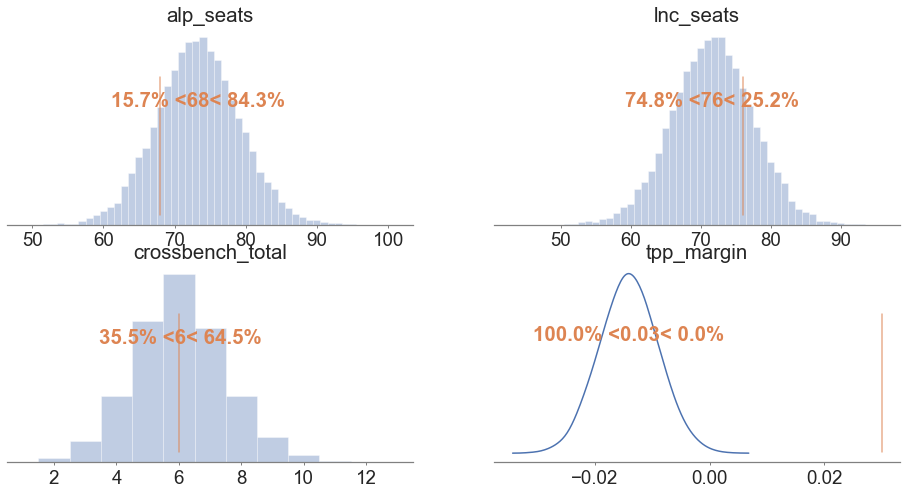

In [7]:
fig, ax = plt.subplots(2,2, figsize=[16,8])
for var in final_ref_vals:
    _ = az.plot_posterior(trace, var_names=var, point_estimate=None, credible_interval=None, ax=ax[final_axes[var]], round_to=2, ref_val=final_ref_vals[var])

Here's what we get at the end. 

4 different probability distributions. 

x-axis is all the different possible outcomes for each variable

y-axis is the relative probability of that outcome

We'll have a better look at this at the end

Uncertainty:
- Polls
    - sampling error from small samples
    - other survey error
    - people changing their minds
- Translating polls to seats: "uniform swings" are not a thing

## Overview
1. <font color=grey>Probabilistic forecasting
2. Defining the problem (Australian election primer)</font>
3. Building a model in PyMC3

## Building a model in PyMC3

<img style="width:60%" src="../img/PyMC3_banner.svg">

In [8]:
import pymc3 as pm

Introduce PyMC 

> PyMC3 is a probabilistic programming package for Python that allows users to fit Bayesian models using a variety of numerical methods... 
> PyMC3 strives to make Bayesian modeling as simple and painless as possible, allowing users to focus on their scientific problem, rather than on the methods used to solve it.

PyMC3 uses a sampling method called Markov Chain Monte Carlo. 

Briefly, this refers to a class of methods for sampling from a probability distribution in order to construct the most likely distribution. When it's difficult to explicitly calculate the probability distribution we are interested in we can generate samples to estimate that distribution. 

If that doesn't make sense, don't worry. The great thing about PyMC3 is that it leaves the maths to the mathematicians and the modelling building to the scientists.

### Bayesian Method
<img style="width:80%" src="../img/bayes.svg">

For PyMC3 to work we have to specify 3 things. 

> In Bayesian statistics, a prior probability distribution of an uncertain quantity is the probability distribution that would express one's beliefs about this quantity before some evidence (or data) is taken into account.

These are our assumptions.

> In statistics, the likelihood function (often simply called likelihood) expresses how likely particular values of statistical parameters are for a given set of observations.

### Step One: Aggregate polls (bayesian parameter estimation)

<img src="../img/model-overview-2.svg">

#### Polls predicted a Labor victory

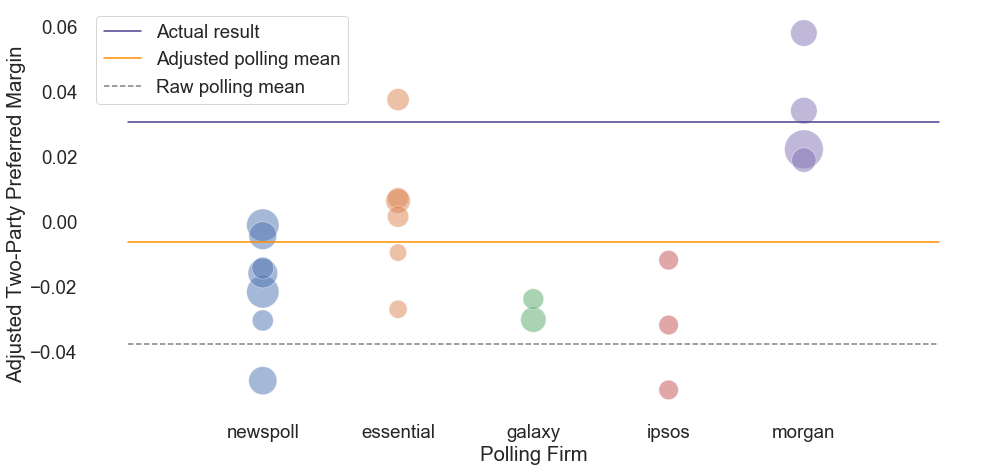

In [9]:
adjusted_mean = polls['tpp_adjusted'].mean()
raw_mean = polls['tpp_margin'].mean()
actual_result = (51.53-48.47)/100
fig, ax = plt.subplots(1,1,figsize=[16, 7.5])
_ = plt.plot([-1,5],[actual_result,actual_result],  color='darkslateblue', label='Actual result')
_ = plt.plot([-1,5],[adjusted_mean,adjusted_mean], color='darkorange', label='Adjusted polling mean')
_ = plt.plot([-1,5],[raw_mean,raw_mean], '--', color='grey', label='Raw polling mean')
_ = sns.scatterplot(x='firm', y='tpp_adjusted', size='std', hue='firm', sizes=(300,1500), alpha=0.5, legend=False, data=polls, ax=ax)
ax.set(xlabel = "Polling Firm", ylabel="Adjusted Two-Party Preferred Margin ")
sns.despine(left=True, bottom=True)
_ = ax.legend(loc = 'best')


X axis: 5 different polling firms included in the forecast

Dots: Each point is a particular poll released by that firm, bigger has less weight, smaller has more weight

Y axis: _Adjusted_ two-party preferred margin based on the historical accuracy of the polling firms

<b>We are trying to combine these polls into a single _probabilistic_ estimate of the two-party preferred vote.</b>

When we're forecasting probabilistically, we're saying that there is an unobserved "real" two-party preferred margin that each pollis an imperfect estimate of. We want to combine all these imperfect estimates into one probabilistic estimate. 

#### What is the universe of possible two-party preferred margins?
<img style="width:80%" src="../img/prior.svg">

In [10]:
with pm.Model() as tpp_model:
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1)
    tpp_prior = pm.sample(draws=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpp_margin]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2498.33draws/s]


PyMC3 uses the "with" context to hold its models together

Uniform distribution: -1 to 1

Let PyMC3 do it's MCMC magic

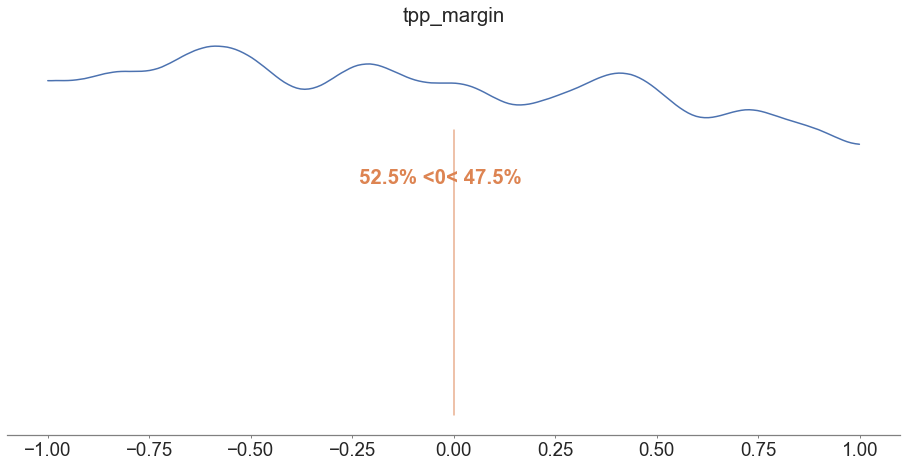

In [11]:
fig, ax = plt.subplots(1,1, figsize=[16, 7.5])
_ = az.plot_posterior(tpp_prior, combined=True, credible_interval=None, point_estimate=None, ax=ax, ref_val=0)

- This is a probability density function.
- Along the x-axis are all the possible values of the two-party preferred margin. 
- The y-axis represents the relative probability of the different values
- You can see here that all values from -1 to 1 have similar probabilities because we haven't included any data in the model yet.

#### Specify a likelihood and add some data
<img style="width:80%" src="../img/bayes.svg">

In [12]:
with pm.Model() as tpp_model:
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) # prior
    tpp_likelihood = pm.Normal('tpp_likelihood', 
                               tpp_margin, 
                               sd = polls['std'], 
                               observed = polls['tpp_adjusted'])
    trace = pm.sample(draws=1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tpp_margin]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2579.67draws/s]


> Likelihood: expresses how likely particular values of statistical parameters are for a given set of observations

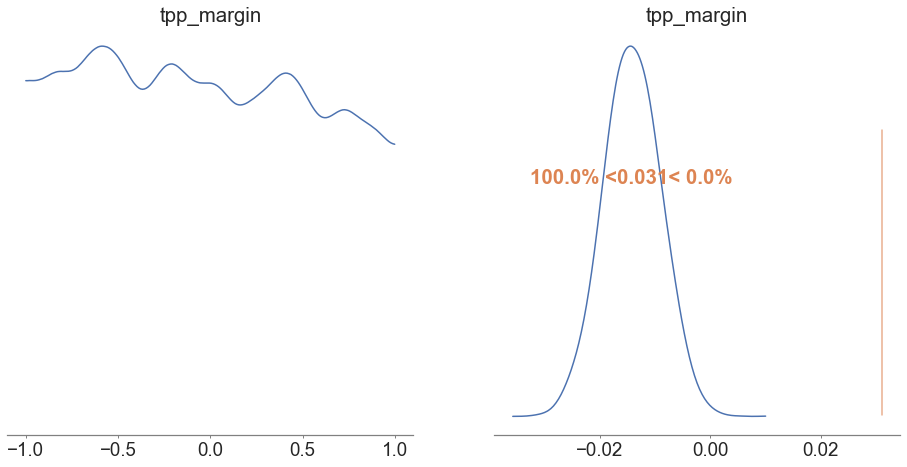

In [13]:
fig, ax = plt.subplots(1,2, figsize=[16, 7.5])
_ = az.plot_posterior(tpp_prior, combined=True, credible_interval=None, point_estimate=None, ax=ax[0]) 
_ = az.plot_posterior(trace, combined=True, credible_interval=None, point_estimate=None, ax=ax[1], round_to=2, ref_val=0.031)

<b>Can we take this shoddy estimate of the two-party preferred vote and still use it to forecast the election?</b>

Left - original prior:
- Note the x axis goes all the way from -1 to 1. 

On the right is our "posterior" probability distribution, the estimate given after we've shown the model our data.

Right - "posterior" probability distribution with our data included:
- x-axis spans -0.03 to 0.03
- y-axis again shows relative probability
- actual result is outside the range of our probabilities
- shoddy estimate of the two-party preferred
- Can we still use it to predict the outcome? 

### From the two-party preferred vote to the seats a party will win (Bayesian linear regression)

<img src="../img/model-overview-3.svg">

#### Look at the data: Historical election results

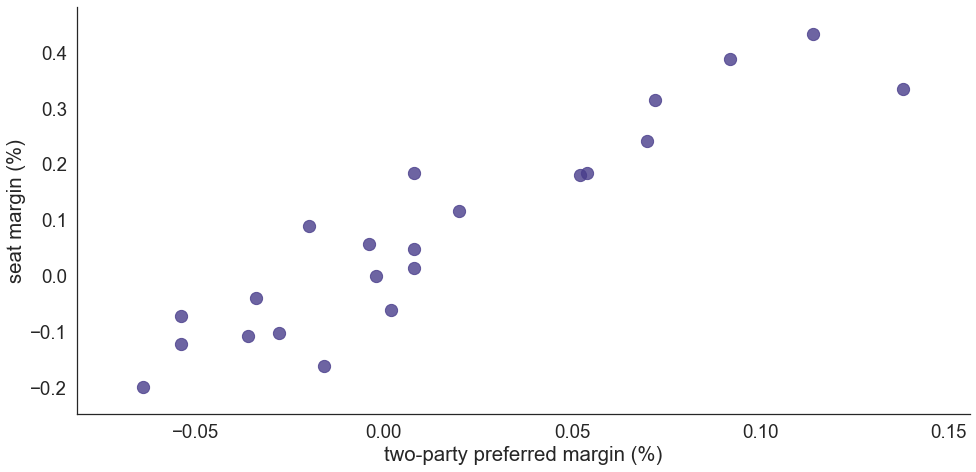

In [14]:
fig, ax = plt.subplots(1,1, figsize=[16,7.5])
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color="darkslateblue", s=150, alpha=0.8)
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seat margin (%)")
sns.despine()

X-axis: two-party preferred margin
y-axis: seat margin between two parties

Dots represent different elections

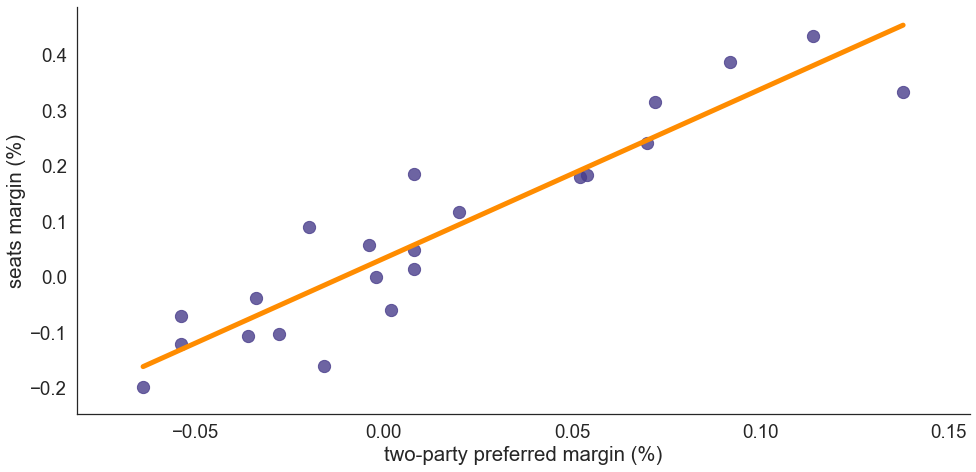

In [15]:
fig, ax = plt.subplots(1,1, figsize=[16,7.5])
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color="darkslateblue", s=150, alpha=0.8)
_ = plt.plot(np.unique(past_elections['tpp_margin']), np.poly1d(np.polyfit(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], 1))(np.unique(past_elections['tpp_margin'])),color="darkorange", linewidth=5)
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")
sns.despine()

\begin{align}
\\y & = slope \times x +\ intercept\\
\\y & = 3.05 \times x +\ 0.03\\
\end{align}

X-axis: two-party preferred margin
y-axis: seat margin between two parties

Dots represent different election
Line of best fit through these data points.

We don't want _best_ fit we want probabilistically fit. 

#### Specify priors.
<img style="width:80%" src="../img/prior.svg">

In [16]:
with pm.Model() as linreg_model:
    slope = pm.Normal('slope', 0, sd=10)
    intercept = pm.Normal('intercept', 0, sd=10)
    error = pm.HalfCauchy('error', 1)
    linreg_priors = pm.sample(draws=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, slope]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2019.50draws/s]


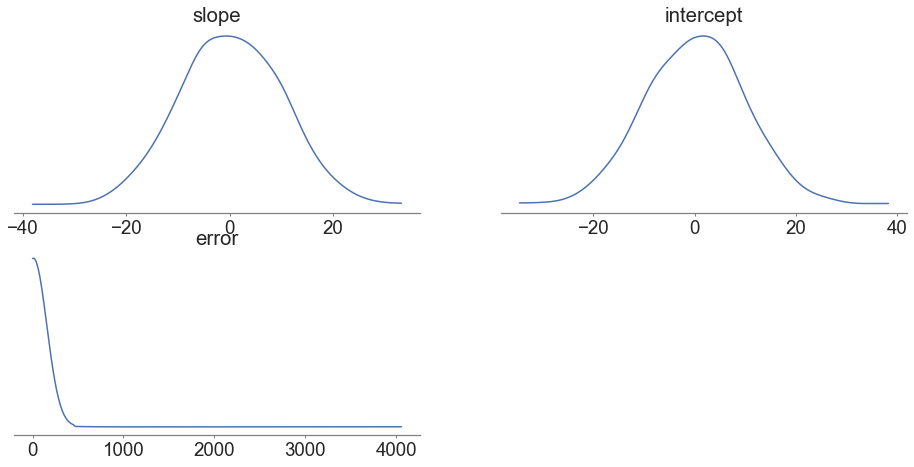

In [17]:
fig, ax = plt.subplots(2,2, figsize=[16,7.5])
_ = az.plot_posterior(linreg_priors, combined=True, credible_interval=None, point_estimate=None, ax=ax)
ax[1,1].set_visible(False)

- Three priors: slope, intercept and error
- x-axes: wide distributions of possible outcomes, not uniform because we don't want to limit them
- y-axes: relative probabilities of those outcomes

#### Specify likelihood.
<img style="width:80%" src="../img/bayes.svg">

In [18]:
with linreg_model:
    y = intercept + slope * past_elections['tpp_margin']
    # tpp2seat likelihood
    tpp2seat_like = pm.Normal('linreg_likelihood', 
                              y, 
                              sd = error, 
                              observed = past_elections['seat_margin_pc_majors'])
    trace = pm.sample(draws=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, slope]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1616.43draws/s]


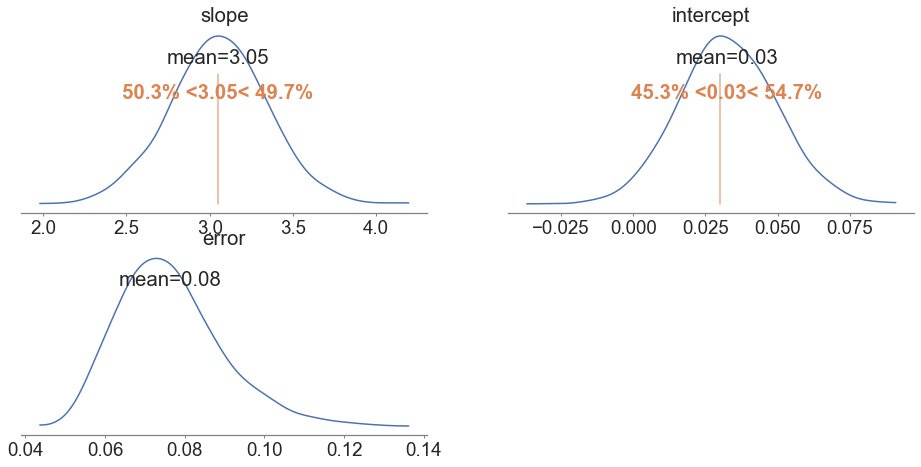

In [19]:
fig, ax = plt.subplots(2,2, figsize=[16,7.5]); ref_vals = {'slope': 3.05,'intercept': 0.03,'error': None}; axes = {'slope': (0,0),'intercept': (0,1),'error': (1,0)}
for var in ref_vals.keys():
    _ = az.plot_posterior(trace, var_names=var, combined=True, credible_interval=None, ax=ax[axes[var]], round_to=2, ref_val=ref_vals[var])
ax[1,1].set_visible(False)

Posterior distributions updated with our data

Range of x-axes is markedly reduced

Line of best fit parameters are marked in orange - we've still got our best guess, we've now just got probability distributions associated with them

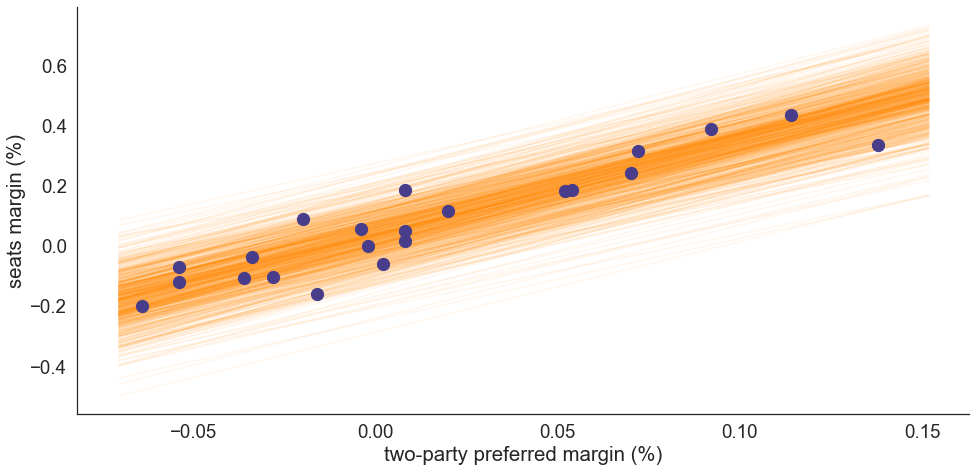

In [20]:
df = pm.trace_to_dataframe(trace)
fig, ax = plt.subplots(1,1, figsize=[16,7.5])
_ = plt.scatter(past_elections['tpp_margin'], past_elections['seat_margin_pc_majors'], color='darkslateblue', zorder=501, s=150)
for i in range(700):
    line_x = pd.DataFrame([past_elections['tpp_margin'].min()*1.1, past_elections['tpp_margin'].max()*1.1])
    line_y = line_x * df.loc[i,'slope'] + df.loc[i,'intercept'] + np.random.normal(loc=0.0, scale=df.loc[i,'error'])
    _ = plt.plot(line_x, line_y, color='darkorange', alpha=0.07, zorder=500-i)
_ = plt.xlabel("two-party preferred margin (%)")
_ = plt.ylabel("seats margin (%)")
sns.despine()

Another way to visualise the posterior

X-axis: two-party preferred margin
y-axis: seat margin between two parties

Dots represent different election
Underneath are 700 lines taken from the sampled posterior distribution. 

Probabilistic estimates cover all previous outcomes

### Crossbench (homework)

In [21]:
with pm.Model() as all_together:
    p_retain = pm.Beta('p_retain', alpha=1, beta=1)
    crossbench_retain_like = pm.Binomial('crossbench_retain_like', n=crossbench_stats['crossbench_running'], p=p_retain, observed=crossbench_stats['crossbench_retain'])
    crossbench_retain = pm.Binomial('crossbench_retain', n=6, p=p_retain)

    p_gain = pm.Beta('p_gain', alpha=1, beta=1)
    crossbench_gain_like = pm.Binomial('crossbench_gain_like', n=crossbench_stats['gain_opportunities'], p=p_gain, observed=crossbench_stats['crossbench_gain'])
    crossbench_gain = pm.Binomial('crossbench_gain', n=145, p=p_gain)

    crossbench_total = pm.Deterministic('crossbench_total', crossbench_gain + crossbench_retain)

Not going to step through this today

Go through the same process: priors, likelihood, data, posterior

### Putting it all together

<img src="../img/model-overview-4.svg">

In [22]:
with all_together:
    # aggregate polls
    tpp_margin = pm.Uniform('tpp_margin', lower=-1, upper=1) # prior
    tpp_likelihood = pm.Normal('tpp_likelihood', 
                               tpp_margin, 
                               sd = polls['std'], 
                               observed = polls['tpp_adjusted'])

    #estimate relationship between tpp_margin and seat_margin
    slope = pm.Normal('slope', 0, sd=10) #prior
    intercept = pm.Normal('intercept', 0, sd=10) #prior
    error = pm.HalfCauchy('error', 1) #prior
    y = intercept + slope * past_elections['tpp_margin'] #define relationship
    tpp2seat_like = pm.Normal('linreg_likelihood', 
                              y, 
                              sd = error, 
                              observed = past_elections['seat_margin_pc_majors']) #likelihood
    
    # combine tpp_margin estimate with our linear relationship
    seat_margin_pc = pm.Normal('seat_margin_pc', 
                               intercept + slope * tpp_margin, 
                               sd = error) #combine estimates
    
    majors_seats = (151.0 - crossbench_total)
    seat_margin_temp = majors_seats * seat_margin_pc
    lnc_seats = pm.Deterministic('lnc_seats', tt.round((majors_seats/2.0) + (seat_margin_temp/2.0)).astype('int8'))
    alp_seats = pm.Deterministic('alp_seats', tt.round((majors_seats/2.0) - (seat_margin_temp/2.0)).astype('int8'))

    majors_seat_margin = pm.Deterministic('majors_seat_margin', lnc_seats - alp_seats)
    trace = pm.sample(draws=5000,tune=1000, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [seat_margin_pc, error, intercept, slope, tpp_margin, p_gain, p_retain]
>CompoundStep
>>Metropolis: [crossbench_gain]
>>Metropolis: [crossbench_retain]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:34<00:00, 687.96draws/s]
The number of effective samples is smaller than 25% for some parameters.


Here's all the bits and pieces we've been through already in one place. Most of this code you've already seen. 

First, we specify our prior for the two-party preferred margin, then we update that prior with polling data to generate our estimate. 

Then we specify our priors for the linear relationship between two-party preferred margin and seat margin, then we update those priors using the data. 

Line 20 is a really key line, that's where we take the estimates from those two seperate estimates and combine them together. So we take our estimate of the two-party preferred margin from polling data and our estimates of slope, intercept and sigma and combine them all together. 

The last 6 lines of code are just math to resolve the actual number of seats ear party will win. 

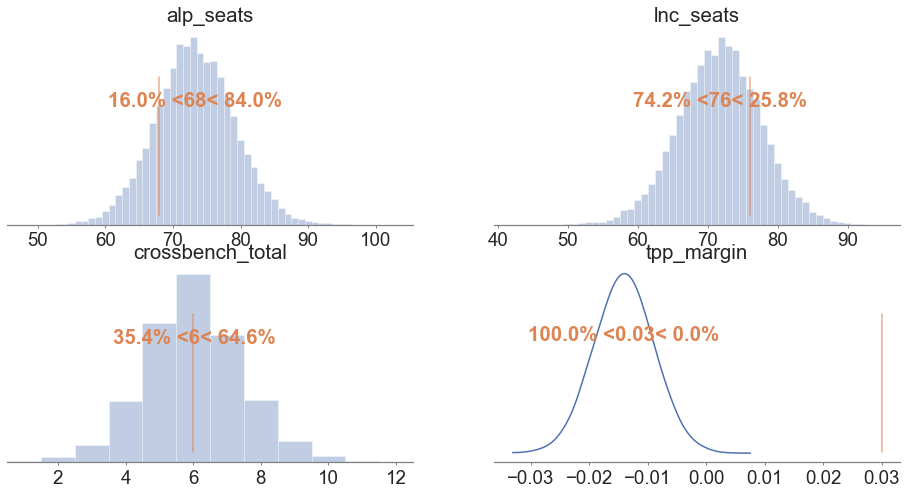

In [23]:
fig, ax = plt.subplots(2,2, figsize=[16,8])
for var in final_ref_vals:
    _ = az.plot_posterior(trace, var_names=var, point_estimate=None, credible_interval=None, ax=ax[final_axes[var]], round_to=2, ref_val=final_ref_vals[var])

## Who will win?
 <img src="../img/model-overview-full.svg">

In [24]:
print("Coalition win majority: {:.2f}%".format((trace['lnc_seats'] >= 76).mean()*100))
print("ALP win majority: {:.2f}%".format((trace['alp_seats'] >= 76).mean()*100))
print("Minority government (neither party wins absolute majority): {:.2f}%".format(((trace['lnc_seats'] <76 ) & (trace['alp_seats'] < 76)).mean()*100))

Coalition win majority: 25.82%
ALP win majority: 34.92%
Minority government (neither party wins absolute majority): 39.26%


Sometimes unlikely things happen. If you flip a coin twice and get heads both times, that's the same chance our forecast had of the Coalition winning the election. If we take an umbrella on a day with a 25% chace of rain, we should be surprised when the Coalition won. 

We can take a pretty crap estimate of the two-party preferred margin but because we estimate uncertainty in other parts of the model, our end result isn't too far off. 

We didn't "predict" the Coalition would win, we assigned 

# Thank you!

> Sometimes something other than the most likely outcome happens

## Free Resources

[ThinkBayes](https://greenteapress.com/wp/think-bayes/) by [Allen Downey](https://greenteapress.com/wp/think-bayes/)

[Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) by Cameron Davidson-Pilon

## Me

[buckleysandnone.com](https://www.buckleysandnone.come)

[twitter.com/martintburgess](https://twitter.com/martintburgess)

[nousgroup.com](https://www.nousgroup.com/)
